<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Current weather data: divergent and rotational decomposition on the sphere</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

Uses [Siphon](https://unidata.github.io/siphon/latest/) and [xarray](https://xarray.pydata.org/en/stable/index.html) and [windspharm](https://ajdawson.github.io/windspharm/latest/). Writes .nc file to local directory. 

In [80]:
# for test plots
%matplotlib inline 

# 1 degree data is fine enough
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_onedeg/catalog.xml?dataset=grib/NCEP/GFS/Global_onedeg/Best')
best_gfs.datasets

['Best GFS One Degree Forecast Time Series']

In [81]:
best_ds = list(best_gfs.datasets.values())[0]
ncss = best_ds.subset()
query = ncss.query()

We can look at the `ncss.variables` object to see what variables are available from the dataset:

In [100]:
# ncss.variables        # long list

## Take current data, global, u and v

In [101]:
from datetime import datetime

query.time(datetime.utcnow())

# query.vertical_level(20000) # Pascals? Yes according to this example, but CAREFUL!
# https://unidata.github.io/siphon/latest/examples/ncss/NCSS_Timeseries_Examples.html?highlight=vertical

query.accept('netcdf4')
query.variables('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 'Geopotential_height_isobaric')


var=Geopotential_height_isobaric&var=u-component_of_wind_isobaric&var=v-component_of_wind_isobaric&time=2021-09-07T14%3A37%3A02.547278&accept=netcdf4

# We now request data from the server using this query. 
The `NCSS` class handles parsing this NetCDF data (using the `netCDF4` module). If we print out the variable names, we see our requested variables, as well as a few others (more metadata information)

In [214]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))

In [103]:
u = data['u-component_of_wind_isobaric'] #.squeeze() # squeeze off the time dimension
v = data['v-component_of_wind_isobaric'] #.squeeze()
Z = data['Geopotential_height_isobaric'] #.squeeze()

# windspharm processing and write-out

In [111]:
import windspharm

In [112]:
V = windspharm.xarray.VectorWind(u,v)   # seems to work for all levels at once

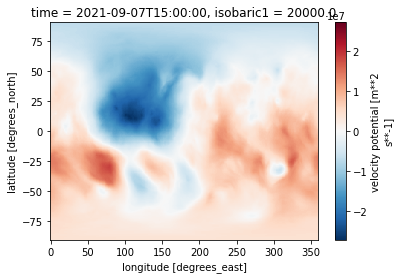

In [232]:
psi = V.streamfunction()
chi = V.velocitypotential()
Vdiv= V.irrotationalcomponent()
Vrot= V.nondivergentcomponent()

chi.sel(isobaric1=20000).plot()

In [233]:
# Test the completeness of the decomposition: just speckle (gridscale noise) mostly
udif = u - Vrot[0]-Vdiv[0]
vdif = v - Vrot[1]-Vdiv[1]
#vdif.sel(isobaric1=20000).plot()

In [123]:
Windspharm_outputs = chi.to_dataset()

In [126]:
Windspharm_outputs['streamfunction'] = psi
Windspharm_outputs['geopotential'] = Z
Windspharm_outputs['urot'] = Vrot[0]
Windspharm_outputs['vrot'] = Vrot[1]
Windspharm_outputs['udiv'] = Vdiv[0]
Windspharm_outputs['vdiv'] = Vdiv[1]
Windspharm_outputs['u'] = u
Windspharm_outputs['v'] = v

In [127]:
Windspharm_outputs.to_netcdf('test.nc')

# Some global analyses 
1. Are Vrot and Vdiv globally orthogonal? 

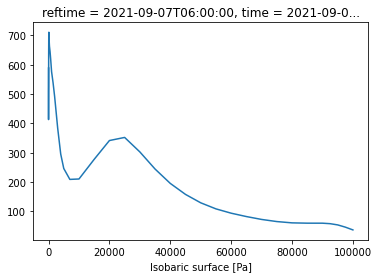

In [156]:
KE = (u*u + v*v)/2
KE.mean(dim=['lat','lon']).plot()

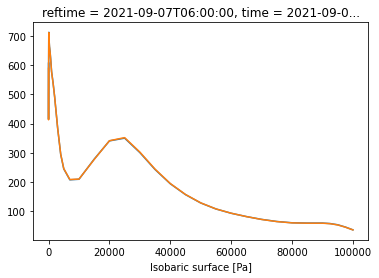

In [182]:
KEdiv = (Vdiv[0]*Vdiv[0] + Vdiv[1]*Vdiv[1])/2
KErot = (Vrot[0]*Vrot[0] + Vrot[1]*Vrot[1])/2

# Plot KE of Vrot, Vdiv, and total 
(KErot + KEdiv).mean(dim=['lat','lon']).plot()
KE.mean(dim=['lat','lon']).plot() 

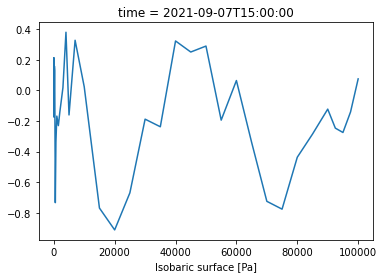

In [212]:
# Is the cross term small? Perhaps vanishingly so? Yes, and no. 
# The cross term is a KE source, See global energetics equations at 
# https://journals.ametsoc.org/view/journals/atsc/55/15/1520-0469_1998_055_2530_asosam_2.0.co_2.xml

cross = (Vdiv[0]*Vrot[0] + Vdiv[1]*Vrot[1])/2
ratio = cross/KEdiv
ratio.mean(dim=['lat','lon']).plot()

In [234]:
%reload_ext ipyidv

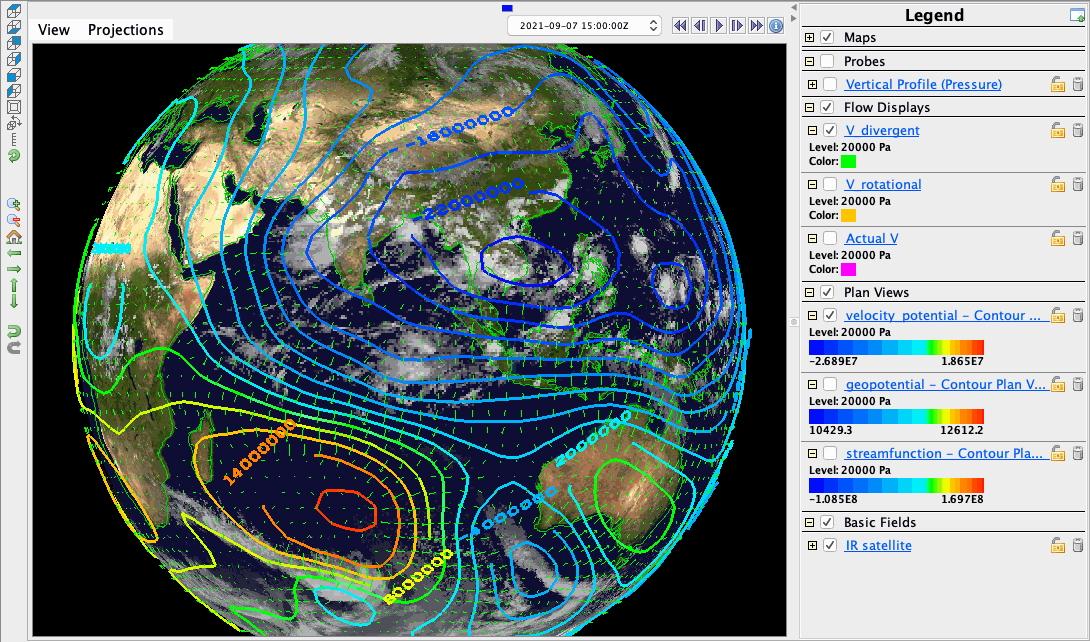

In [237]:
%make_image -capture legend 

In [ ]:
%make_movie -capture legend 